# Sign Recognition Project

## Dataset Preprocessing

In [62]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import xml.etree.ElementTree as ET
import random
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


### Dataset Extraction

Parsing the XML and loading the images

In [63]:
DATASET_DIR = "."
IMAGES_DIR = "./road-sign-detection/images"
ANN_DIR = "./road-sign-detection/annotations"

print("Number of images :", len(os.listdir(IMAGES_DIR)))
print("Number of annotations :", len(os.listdir(ANN_DIR)))


Number of images : 877
Number of annotations : 873


In [64]:
def parse_voc_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    filename = root.find("filename").text
    objects = []
    
    for obj in root.findall("object"):
        name = obj.find("name").text
        bnd = obj.find("bndbox")
        xmin = int(bnd.find("xmin").text)
        ymin = int(bnd.find("ymin").text)
        xmax = int(bnd.find("xmax").text)
        ymax = int(bnd.find("ymax").text)
        objects.append({
            "label": name,
            "bbox": (xmin, ymin, xmax, ymax)
        })
    
    return filename, objects


### Images formatting

We crop the images to keep only the road sign, and resize the cropped images to $96\times 96$ pixels (each pixel containing 3 values) to have all images in the same dimension. Note that there can be multiple road sign per image.

In [65]:
IMG_SIZE = 96
X = []
y_all = []
y_mask = []

xml_files = sorted(glob.glob(ANN_DIR + "/*.xml"))
for xml_path in xml_files:
    filename, objects = parse_voc_xml(xml_path)
    img_path = IMAGES_DIR + "/" + filename
    if not os.path.exists(img_path):
        continue
    img = Image.open(img_path).convert("RGB")
    for obj in objects:
        label = obj["label"]
        xmin, ymin, xmax, ymax = obj["bbox"]
        crop = img.crop((xmin, ymin, xmax, ymax))
        crop = crop.resize((IMG_SIZE, IMG_SIZE))
        X.append(np.array(crop))
        y_all.append(label)
        y_mask.append("-" in label)
        
X = np.array(X)
y_all = np.array(y_all)

print("Extracted images :", X.shape)
print("Labels :", np.unique(y_all))
print("Speed limits :", np.unique(y_all[y_mask]))


Extracted images : (1240, 96, 96, 3)
Labels : ['crosswalk' 'speedlimit-100' 'speedlimit-120' 'speedlimit-30'
 'speedlimit-40' 'speedlimit-5' 'speedlimit-50' 'speedlimit-60'
 'speedlimit-70' 'speedlimit-80' 'speedlimit-90' 'stop' 'trafficlight']
Speed limits : ['speedlimit-100' 'speedlimit-120' 'speedlimit-30' 'speedlimit-40'
 'speedlimit-5' 'speedlimit-50' 'speedlimit-60' 'speedlimit-70'
 'speedlimit-80' 'speedlimit-90']


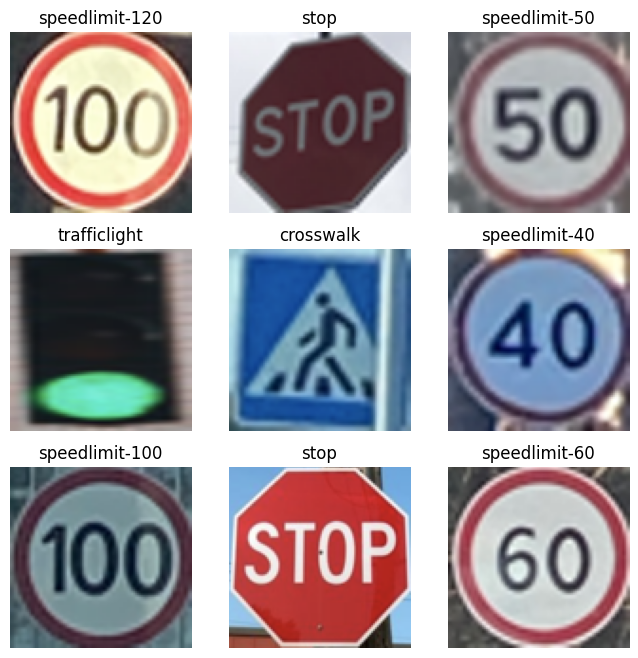

In [66]:
plt.figure(figsize=(8,8))
for i in range(9):
    idx = random.randint(0, len(X)-1)
    plt.subplot(3,3,i+1)
    plt.imshow(X[idx].astype("uint8"))
    plt.title(y_all[idx])
    plt.axis('off')
plt.show()


### Building the Dataset

All classifiers works best with values between 0 and 1.

Note that we are using the label "speedlimit" for classification between roadsigns, meaning label 1 will not appear on the final results (it is a placeholder for first classification).

In [67]:
X = X.astype("float32") / 255.0
X_flat = X.reshape(X.shape[0], -1)

label_encoder = LabelEncoder()
label_str = np.unique(y_all)
label_str = np.append(label_str, ["speedlimit"])
label_encoder.fit(label_str)
y_encoded_all = label_encoder.transform(y_all)

X_train, X_test, y_train_all, y_test_all = train_test_split(
    X_flat, y_encoded_all, test_size=0.2, random_state=42, stratify=y_encoded_all
)

print("Train :", X_train.shape, y_train_all.shape)
print("Test  :", X_test.shape, y_test_all.shape)
print("Classes :", label_encoder.classes_)

y_train = np.copy(y_train_all)
mask = np.isin(y_train, label_encoder.transform(["speedlimit", "crosswalk", "stop", "trafficlight"]))
y_train[~mask] = label_encoder.transform(["speedlimit"])[0]

y_test = np.copy(y_test_all)
mask = np.isin(y_test, label_encoder.transform(["speedlimit", "crosswalk", "stop", "trafficlight"]))
y_test[~mask] = label_encoder.transform(["speedlimit"])[0]

Train : (992, 27648) (992,)
Test  : (248, 27648) (248,)
Classes : ['crosswalk' 'speedlimit' 'speedlimit-100' 'speedlimit-120'
 'speedlimit-30' 'speedlimit-40' 'speedlimit-5' 'speedlimit-50'
 'speedlimit-60' 'speedlimit-70' 'speedlimit-80' 'speedlimit-90' 'stop'
 'trafficlight']


## Comparison of classifiers

### Multinomial Logistic Regression

In [68]:
cls_lr = LogisticRegression(max_iter=200)
cls_lr.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,200
,multi_class,'deprecated'


              precision    recall  f1-score   support

           0       0.97      0.95      0.96        40
           1       0.99      1.00      0.99       156
          12       0.89      0.94      0.92        18
          13       0.91      0.85      0.88        34

    accuracy                           0.97       248
   macro avg       0.94      0.94      0.94       248
weighted avg       0.97      0.97      0.97       248



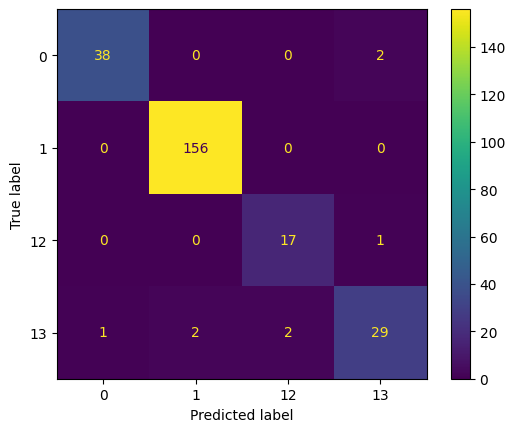

In [69]:
y_predicted_lr = cls_lr.predict(X_test)
print(classification_report(y_test, y_predicted_lr))
ConfusionMatrixDisplay.from_predictions(y_test, y_predicted_lr)
plt.show()

### Support Vector Machine

In [70]:
cls_svm = svm.SVC()
cls_svm.fit(X_train,y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


              precision    recall  f1-score   support

           0       0.95      0.95      0.95        40
           1       0.99      1.00      1.00       156
          12       1.00      0.94      0.97        18
          13       0.94      0.94      0.94        34

    accuracy                           0.98       248
   macro avg       0.97      0.96      0.96       248
weighted avg       0.98      0.98      0.98       248



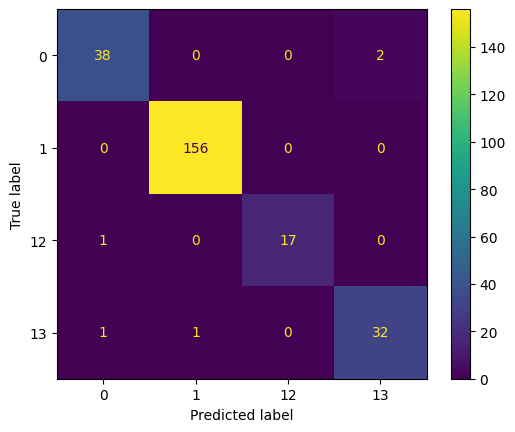

In [71]:
y_predicted_svm = cls_svm.predict(X_test)
print(classification_report(y_test, y_predicted_svm))
ConfusionMatrixDisplay.from_predictions(y_test, y_predicted_svm)
plt.show()

## Gaussian Naive Bayes

In [72]:
cls_gnb = GaussianNB()
cls_gnb.fit(X_train, y_train)

,priors,None
,var_smoothing,1e-09


              precision    recall  f1-score   support

           0       0.82      0.90      0.86        40
           1       0.95      0.86      0.90       156
          12       0.79      0.61      0.69        18
          13       0.55      0.79      0.65        34

    accuracy                           0.84       248
   macro avg       0.78      0.79      0.77       248
weighted avg       0.86      0.84      0.84       248



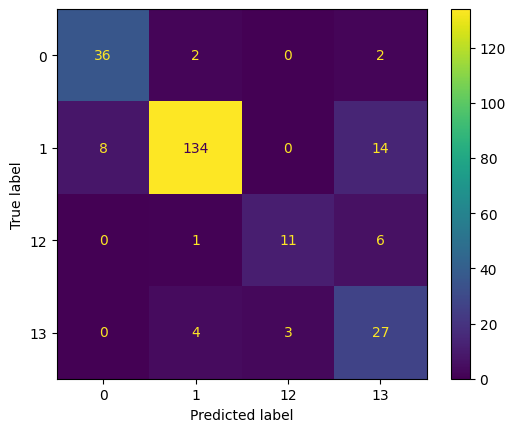

In [73]:
y_predicted_gnb = cls_gnb.predict(X_test)
print(classification_report(y_test, y_predicted_gnb))
ConfusionMatrixDisplay.from_predictions(y_test, y_predicted_gnb, cmap='viridis')
plt.show()

## K Nearest Neighbors

Using the default parameters

In [74]:
cls_knn = KNeighborsClassifier(n_neighbors=5)
cls_knn.fit(X_train, y_train)


,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


              precision    recall  f1-score   support

           0       0.92      0.90      0.91        40
           1       0.91      1.00      0.95       156
          12       0.94      0.89      0.91        18
          13       1.00      0.62      0.76        34

    accuracy                           0.92       248
   macro avg       0.94      0.85      0.89       248
weighted avg       0.93      0.92      0.92       248



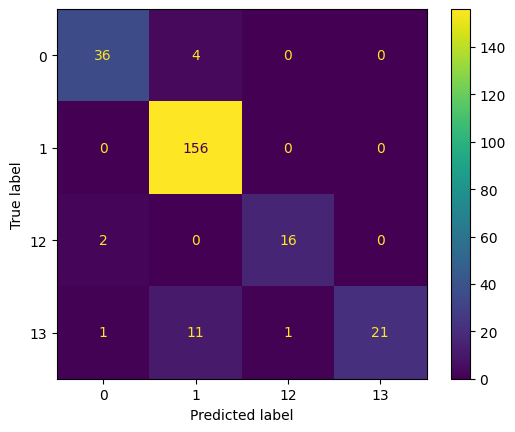

In [75]:
y_predicted_knn = cls_knn.predict(X_test)
print(classification_report(y_test, y_predicted_knn))
ConfusionMatrixDisplay.from_predictions(y_test, y_predicted_knn)
plt.show()

Parameters tuning to find the best accuracy (simple brutefirce over $n$ and the weight function)

In [76]:
best_accuracy = 0
best_params = {}
for n_neighbors in range(1, 11):
    for weights in ['uniform', 'distance']:
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
        knn.fit(X_train, y_train)
        y_predicted_knn = knn.predict(X_test)
        accuracy = accuracy_score(y_test, y_predicted_knn)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'n_neighbors': n_neighbors, 'weights': weights}
print(f'Best accuracy: {best_accuracy}')
print(f'Best parameters: {best_params}')

Best accuracy: 0.9516129032258065
Best parameters: {'n_neighbors': 1, 'weights': 'uniform'}


## Building the dataset (speed limits)

In [77]:
y_train_sl = np.copy(y_train_all)
mask = np.isin(y_train_sl, label_encoder.transform(["speedlimit", "crosswalk", "stop", "trafficlight"]))
y_train_sl = y_train_all[~mask]
X_train_sl = X_train[~mask]

y_test_sl = np.copy(y_test_all)
mask = np.isin(y_test_sl, label_encoder.transform(["speedlimit", "crosswalk", "stop", "trafficlight"]))
y_test_sl = y_test_all[~mask]
X_test_sl = X_test[~mask]

print("Train speedlimit:", X_train_sl.shape, y_train_sl.shape)
print("Test speedlimit :", X_test_sl.shape, y_test_sl.shape)

Train speedlimit: (623, 27648) (623,)
Test speedlimit : (156, 27648) (156,)


## Training the second model

In [78]:
cls_lr_sl = LogisticRegression(max_iter=600)
cls_lr_sl.fit(X_train_sl, y_train_sl)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,600
,multi_class,'deprecated'


              precision    recall  f1-score   support

           2       0.78      0.78      0.78        27
           3       0.64      0.64      0.64        14
           4       0.80      0.80      0.80         5
           5       0.95      0.84      0.89        44
           6       1.00      1.00      1.00         6
           7       0.75      0.50      0.60         6
           8       0.86      0.86      0.86         7
           9       0.60      0.60      0.60         5
          10       0.79      0.90      0.84        29
          11       0.81      1.00      0.90        13

    accuracy                           0.82       156
   macro avg       0.80      0.79      0.79       156
weighted avg       0.82      0.82      0.82       156



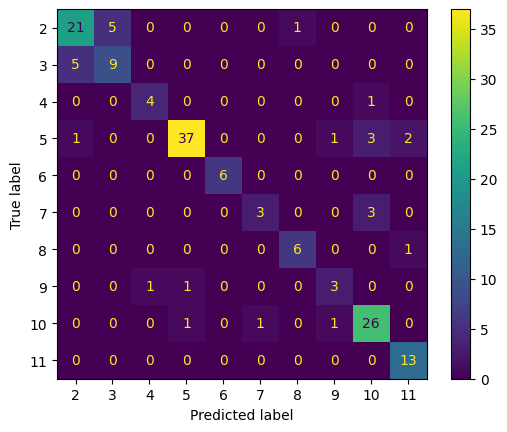

In [79]:
y_predicted_lr_sl = cls_lr_sl.predict(X_test_sl)
print(classification_report(y_test_sl, y_predicted_lr_sl))
ConfusionMatrixDisplay.from_predictions(y_test_sl, y_predicted_lr_sl)
plt.show()

## Combining the models

Replacing data to build the final prediction

In [80]:
y_predicted = np.copy(y_predicted_svm)
mask = np.isin(y_predicted, label_encoder.transform(["speedlimit"]))
y_predicted[mask] = cls_lr_sl.predict(X_test[mask])

Confusion matrixes (recall)

Stage 1: Support Vector Machine, classification between road signs
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        40
           1       0.99      1.00      1.00       156
          12       1.00      0.94      0.97        18
          13       0.94      0.94      0.94        34

    accuracy                           0.98       248
   macro avg       0.97      0.96      0.96       248
weighted avg       0.98      0.98      0.98       248



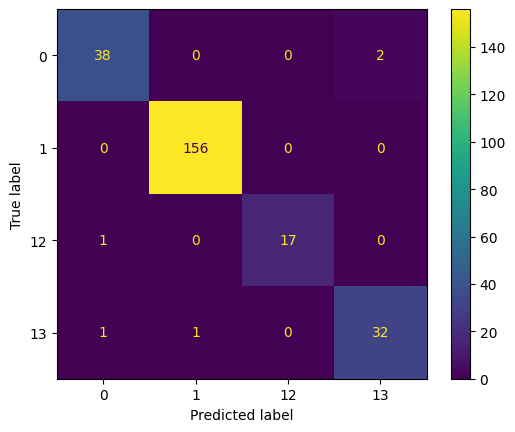

Stage 2: Logistic Regression, classification between speed limits (classified by the stage 1)
              precision    recall  f1-score   support

           2       0.78      0.78      0.78        27
           3       0.64      0.64      0.64        14
           4       0.80      0.80      0.80         5
           5       0.95      0.84      0.89        44
           6       1.00      1.00      1.00         6
           7       0.75      0.50      0.60         6
           8       0.86      0.86      0.86         7
           9       0.60      0.60      0.60         5
          10       0.79      0.90      0.84        29
          11       0.81      1.00      0.90        13

    accuracy                           0.82       156
   macro avg       0.80      0.79      0.79       156
weighted avg       0.82      0.82      0.82       156



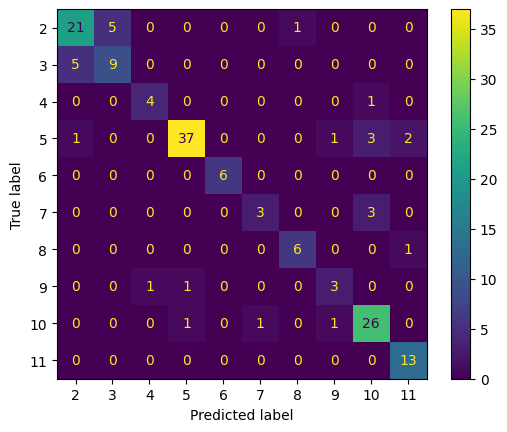

Total: classification between road signs and speed limits
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        40
           2       0.78      0.78      0.78        27
           3       0.64      0.64      0.64        14
           4       0.80      0.80      0.80         5
           5       0.95      0.84      0.89        44
           6       1.00      1.00      1.00         6
           7       0.75      0.50      0.60         6
           8       0.86      0.86      0.86         7
           9       0.60      0.60      0.60         5
          10       0.79      0.90      0.84        29
          11       0.76      1.00      0.87        13
          12       1.00      0.94      0.97        18
          13       0.94      0.94      0.94        34

    accuracy                           0.87       248
   macro avg       0.83      0.83      0.83       248
weighted avg       0.87      0.87      0.87       248



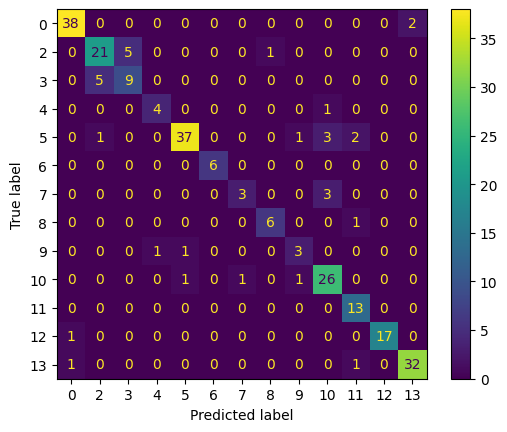

In [81]:
print("Stage 1: Support Vector Machine, classification between road signs")

print(classification_report(y_test, y_predicted_svm))
ConfusionMatrixDisplay.from_predictions(y_test, y_predicted_svm)
plt.show()

print("Stage 2: Logistic Regression, classification between speed limits (classified by the stage 1)")

print(classification_report(y_test_sl, y_predicted_lr_sl))
ConfusionMatrixDisplay.from_predictions(y_test_sl, y_predicted_lr_sl)
plt.show()

print("Total: classification between road signs and speed limits")

print(classification_report(y_test_all, y_predicted))
ConfusionMatrixDisplay.from_predictions(y_test_all, y_predicted)
plt.show()

## Conclusion

Even if it takes time to run, the most accurate classifier is the Support Vector Machine classifier

After obtaining the satisfying accuracy display numbers which the model misclassified.

Total number of missclassification : 33


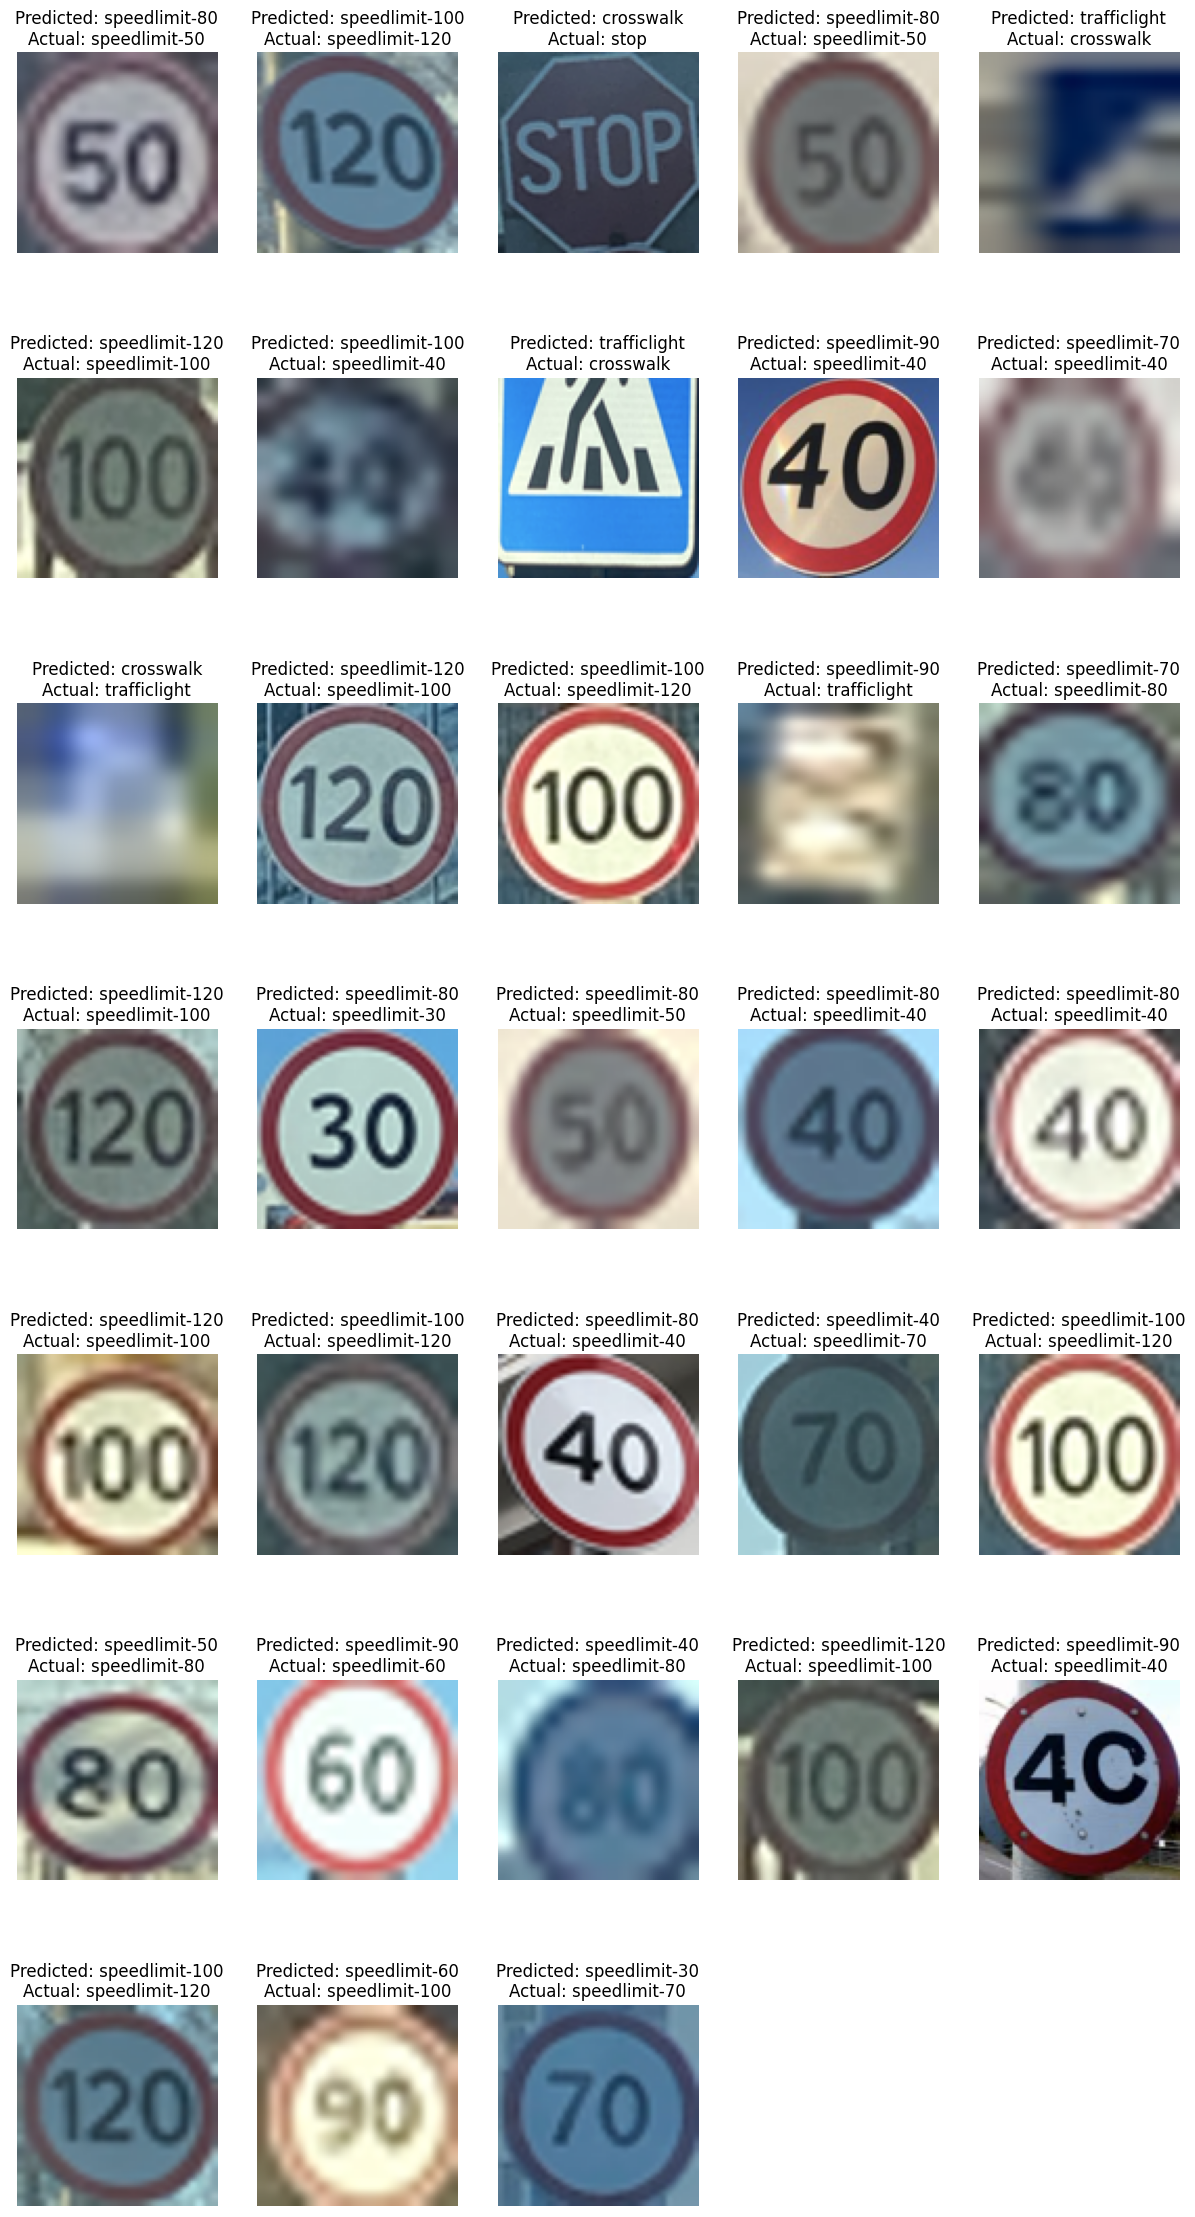

In [82]:
y_missclassified_mask = y_predicted != y_test_all

print("Total number of missclassification :", y_missclassified_mask.sum())

y_missclassified_computed = label_encoder.inverse_transform(y_predicted[y_missclassified_mask])
y_missclassified_test = label_encoder.inverse_transform(y_test_all[y_missclassified_mask])
X_missclassified = X_test[y_missclassified_mask]

n = len(y_missclassified_computed)

X_missclassified = (X_missclassified.astype("float32") * 255.0).astype("uint8")

rows = (n + 4) // 5
fig, axes = plt.subplots(nrows=rows, ncols=5, figsize=(15, rows * 4))
for i in range(n):
    plt.subplot(rows, 5, i+1)
    plt.imshow(X_missclassified[i].reshape(96, 96, 3))
    plt.title("Predicted: " + y_missclassified_computed[i] + "\nActual: " + y_missclassified_test[i])
    plt.axis('off')
    plt.subplots_adjust(hspace=0.6)


# Hide unused plot spots at the end
for j in range(n, rows * 5):
    axes.flatten()[j].axis('off')

plt.show()
